In [1]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import uproot
import numpy as np
import awkward as ak
from torch.utils.data import DataLoader
import torch
import datetime
import numpy as np
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
import awkward as ak
# PyTorch Lightning
import pytorch_lightning as L
#from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
#from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar
from torchmetrics.classification import BinaryConfusionMatrix
from torchmetrics.classification import BinaryAccuracy
#from pytorch_lightning.callbacks import LearningRateMonito

In [2]:
import uproot
### Energy = 0.15 GeV
root_file1 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF1.root")
root_file2 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF2.root")
tree1 = root_file1["Samples"]
tree2 = root_file2["Samples"]
arrays1 = tree1.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
arrays2 = tree2.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays1["samples"])
X_real = X_real/np.max(X_real, axis = 1).reshape(200000,1)
y_real = ak.to_numpy(arrays1["ysamples"])
X_noise = ak.to_numpy(arrays2["samplesNoise"])
X_noise = X_noise/np.max(X_noise, axis = 1).reshape(200000,1)
y_noise = ak.to_numpy(arrays2["ysamplesNoise"])

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
labels = np.concatenate([y_real, y_noise])


# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning

shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]

[[-2.18991428 -1.33758012 -0.16379419 ...  0.97133729  0.38098346
  -1.97539871]
 [-0.02620282  0.3494965   0.54694886 ...  0.55314748  0.19741884
  -0.15557223]
 [ 0.70501369  0.95452037  1.         ...  0.82044019  0.71309163
   0.61413221]
 ...
 [-0.03224206 -0.11911494  0.25985249 ...  0.45905995  0.7742844
   1.        ]
 [ 0.42559843  0.71037992  0.30653368 ...  0.96303223  1.
   0.64932407]
 [-0.13804387  0.03573051 -0.07850811 ...  0.81263918  0.81864257
   0.44620173]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [3]:
import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.7 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
valid_size = train_size + int(0.1 * num_events_data)
train_data = data[:train_size]
train_labels = labels[:train_size]
valid_data = data[train_size:valid_size]
valid_labels = labels[train_size:valid_size]
test_data = data[valid_size:]
test_labels = labels[valid_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : validation data: {len(data)} : {len(train_data)} : {len(test_data)} : {len(valid_data)}')

number of rows in data is 400000
number of rows in data is 10
Size of training data is 280000
number of elements in data : training data : test data : validation data: 400000 : 280000 : 80000 : 40000


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [5]:
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
valid_data = valid_data.reshape((valid_data.shape[0], valid_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], 1))
test_labels = test_labels.reshape((test_labels.shape[0], 1))
valid_labels = valid_labels.reshape((valid_labels.shape[0], 1))

In [6]:
train_data = torch.tensor(train_data, dtype =torch.float).to(device)
test_data = torch.tensor(test_data, dtype =torch.float).to(device)
valid_data = torch.tensor(valid_data, dtype =torch.float).to(device)
train_labels = torch.tensor(train_labels, dtype =torch.float).to(device)
test_labels = torch.tensor(test_labels, dtype =torch.float).to(device)
valid_labels = torch.tensor(valid_labels, dtype =torch.float).to(device)

In [7]:
class ClassifierDataset(Dataset):
    """
    Dataset class used for classifier models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        lebel: torch.tensor
        ) -> None:
        
        super().__init__()

        self.data = data
        self.lebel = lebel

        print("data size = {}".format(data.size()))
        print("target size = {}".format(lebel.size()))
            

    def __len__(self):
        
        return self.data.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        data = self.data[index]
        lebel = self.lebel[index]
        return data, lebel

In [8]:
training_class = ClassifierDataset(
    data = train_data,
    lebel = train_labels)

data size = torch.Size([280000, 10, 1])
target size = torch.Size([280000, 1])


In [9]:
testing_class = ClassifierDataset(
    data = test_data,
    lebel = test_labels)

data size = torch.Size([80000, 10, 1])
target size = torch.Size([80000, 1])


In [10]:
validing_class = ClassifierDataset(
    data = valid_data,
    lebel = valid_labels)

data size = torch.Size([40000, 10, 1])
target size = torch.Size([40000, 1])


In [11]:
class PositionalEncoder(nn.Module):

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=10, 
        d_model: int=512,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            
            pe[0, :, 0::2] = torch.sin(position * div_term)
            
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
        
            pe[:, 0, 0::2] = torch.sin(position * div_term)
        
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [12]:
class TimeSeriesClassifier(L.LightningModule):

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        dim_val: int=32,  
        n_encoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.0, 
        dropout_pos_enc: float=0.0,
        dim_feedforward_encoder: int=2048,
        lr = 0.0001,
        warmup = 100
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 .
        """

        super().__init__() 
        self.save_hyperparameters()
        self._create_model()
        
    def _create_model(self):
        
        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=self.hparams.input_size, 
            out_features=self.hparams.dim_val 
            )
        
        self.linear_mapping = nn.Linear(
            in_features=self.hparams.dim_val,
            out_features=self.hparams.input_size
            )
        
        self.final_linear_mapping = nn.Linear(
            in_features=self.hparams.dec_seq_len, 
            out_features=self.hparams.input_size
            )
        
        self.output = nn.Sigmoid()
        
        self.activation = nn.Sigmoid()
        
        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=self.hparams.dim_val,
            dropout=self.hparams.dropout_pos_enc
            )

        # Creating the encoder layer 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hparams.dim_val, 
            nhead=self.hparams.n_heads,
            dim_feedforward=self.hparams.dim_feedforward_encoder,
            dropout=self.hparams.dropout_encoder,
            batch_first=self.hparams.batch_first
            )

        # Stack the encoder layers in nn.TransformerEncoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=self.hparams.n_encoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
 
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        
        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        src = self.activation(src)
        
        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder

        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))
        
        # Pass through linear mapping
        linear_output = self.linear_mapping(src) # shape [batch_size, target seq len]
        
        linear_output = self.activation(linear_output)
        
        #print("From model.forward(): output size after linear_mapping = {}".format(linear_output.size()))
        
        linear_output = linear_output.squeeze(-1)
        #print("From model.forward(): output size after unsqeeze = {}".format(linear_output.size()))
        
        # Pass through linear mapping
        final_linear_output = self.final_linear_mapping(linear_output) # shape [batch_size, target seq len]
        #print("From model.forward(): output size after final linear_mapping = {}".format(final_linear_output.size()))
        
        # Final output
        final_output = self.output(final_linear_output)
        #print("From model.forward(): final output size = {}".format(final_output.size()))
        
        return final_output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        # We don't return the lr scheduler because we need to apply it per iteration, not per epoch
        #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        #   optimizer, warmup=self.hparams.warmup, max_iters=2500)
        return optimizer    
    #def optimizer_step(self, *args, **kwargs):
        #super().optimizer_step(*args, **kwargs)
        #self.lr_scheduler.step()  # Step per iteration
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

In [13]:
class Train_TimeSeriesClassifier(TimeSeriesClassifier):
    
    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        criterion = torch.nn.BCELoss()
        prediction = self.forward(inp_data)
        # Compute loss and accuracy 
        loss = criterion(prediction, labels)
        #loss = bi_tempered_logistic_loss(activations=prediction, labels=labels, t1=1.0, t2=1.0).mean()
        # Logging
        self.log("%s_loss" % mode, loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")   

In [14]:
batch_size=128
# Load the training data
training_dataloader = DataLoader(training_class, batch_size= batch_size)
# Load the testing data
testing_dataloader = DataLoader(testing_class, batch_size= batch_size)
# Load the validing data
validing_dataloader = DataLoader(validing_class, batch_size= batch_size)

In [15]:
dec_seq_len = 10 # length of input given to decoder
enc_seq_len = 10 # length of input given to encoder
# initialize checkpoints
#early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min", min_delta = 0.001)
#checkpoint_callback = ModelCheckpoint(save_weights_only=True, monitor="val_loss", mode="min")
#lr_monitor = LearningRateMonitor(logging_interval='step')
#progress_bar = RichProgressBar(leave=True)
trainer = L.Trainer(
        #default_root_dir="/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/",
        #callbacks=[early_stop, progress_bar],
        accelerator="gpu",
        devices=1,
        max_epochs=15,
        #gradient_clip_val=5,
    )
model = Train_TimeSeriesClassifier(
           input_size=1,
           dec_seq_len=enc_seq_len,
           batch_first=True,
           )

trainer.fit(model, training_dataloader, validing_dataloader)

# Test best model on validation and test set
val_result = trainer.test(model, dataloaders=validing_dataloader, verbose=False)
test_result = trainer.test(model, dataloaders=testing_dataloader, verbose=False)
result = {"test_loss": test_result[0]["test_loss"], "val_loss": val_result[0]["test_loss"]}
model = model.to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                      | Type               | Params
-----------------------------------------------------------------
0 | encoder_input_layer       | Linear             | 64    
1 | linear_mapping            | Linear             | 33    
2 | final_linear_mapping      | Linear             | 11    
3 | output                    | Sigmoid            | 0     
4 | activation                | Sigmoid            | 0     
5 | positional_encoding_layer | PositionalEncoder  | 0     
6 | encoder                   | TransformerEncoder | 550 K 
-----------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [16]:
best_model = model

In [17]:
best_model = best_model.to(device)

In [45]:
best_model.eval()

Train_TimeSeriesClassifier(
  (encoder_input_layer): Linear(in_features=1, out_features=32, bias=True)
  (linear_mapping): Linear(in_features=32, out_features=1, bias=True)
  (final_linear_mapping): Linear(in_features=10, out_features=1, bias=True)
  (output): Sigmoid()
  (activation): Sigmoid()
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): D

In [46]:
# Initialize a list to store predictions
predictions = []
true_value = []
# Iterate through the test DataLoader and make predictions
with torch.no_grad():
    for j, (data_, labels_) in enumerate(testing_dataloader):
        outputs = best_model(data_)
        predictions.append(outputs)
        true_value.append(labels_)
        print("iteration--->",j)

iteration---> 0
iteration---> 1
iteration---> 2
iteration---> 3
iteration---> 4
iteration---> 5
iteration---> 6
iteration---> 7
iteration---> 8
iteration---> 9
iteration---> 10
iteration---> 11
iteration---> 12
iteration---> 13
iteration---> 14
iteration---> 15
iteration---> 16
iteration---> 17
iteration---> 18
iteration---> 19
iteration---> 20
iteration---> 21
iteration---> 22
iteration---> 23
iteration---> 24
iteration---> 25
iteration---> 26
iteration---> 27
iteration---> 28
iteration---> 29
iteration---> 30
iteration---> 31
iteration---> 32
iteration---> 33
iteration---> 34
iteration---> 35
iteration---> 36
iteration---> 37
iteration---> 38
iteration---> 39
iteration---> 40
iteration---> 41
iteration---> 42
iteration---> 43
iteration---> 44
iteration---> 45
iteration---> 46
iteration---> 47
iteration---> 48
iteration---> 49
iteration---> 50
iteration---> 51
iteration---> 52
iteration---> 53
iteration---> 54
iteration---> 55
iteration---> 56
iteration---> 57
iteration---> 58
iterati

iteration---> 468
iteration---> 469
iteration---> 470
iteration---> 471
iteration---> 472
iteration---> 473
iteration---> 474
iteration---> 475
iteration---> 476
iteration---> 477
iteration---> 478
iteration---> 479
iteration---> 480
iteration---> 481
iteration---> 482
iteration---> 483
iteration---> 484
iteration---> 485
iteration---> 486
iteration---> 487
iteration---> 488
iteration---> 489
iteration---> 490
iteration---> 491
iteration---> 492
iteration---> 493
iteration---> 494
iteration---> 495
iteration---> 496
iteration---> 497
iteration---> 498
iteration---> 499
iteration---> 500
iteration---> 501
iteration---> 502
iteration---> 503
iteration---> 504
iteration---> 505
iteration---> 506
iteration---> 507
iteration---> 508
iteration---> 509
iteration---> 510
iteration---> 511
iteration---> 512
iteration---> 513
iteration---> 514
iteration---> 515
iteration---> 516
iteration---> 517
iteration---> 518
iteration---> 519
iteration---> 520
iteration---> 521
iteration---> 522
iteration-

In [47]:
# Concatenate the predictions into a single tensor (if needed)
predictions = torch.cat(predictions)
true_value = torch.cat(true_value)

In [48]:
y_test = true_value.data.cpu().numpy()
predictions = predictions.data.cpu().numpy()

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

test labels are: [0. 0. 0. ... 0. 0. 1.]


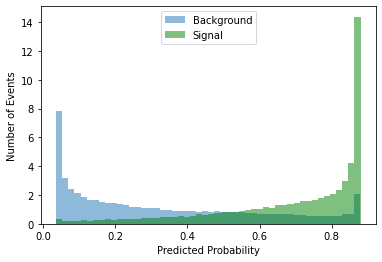

In [76]:
print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5, density=True)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, density=True, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
plt.savefig("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Transformer_Time_Case1.jpg")
plt.show()

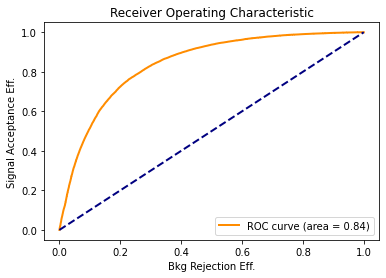

In [77]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Bkg Rejection Eff.')
plt.ylabel('Signal Acceptance Eff.')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
plt.savefig("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Transformer_Time_ROC_Case1.jpg")
plt.show()

In [52]:
target = torch.from_numpy(y_test.flatten())
pred = torch.from_numpy(predictions.flatten())

In [53]:
from torchmetrics.classification import BinaryConfusionMatrix

In [54]:
metric = BinaryConfusionMatrix(threshold=0.7, normalize = 'true')(pred, target)
metric

tensor([[0.8696, 0.1304],
        [0.3989, 0.6011]])

In [78]:
file = uproot.recreate("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_Transformer_SigBkgCase1.root")

In [79]:
file['tree'] = { 
                    "True" : y_test,
                    "Prediction" : predictions
    }

In [80]:
file.close()

In [58]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
import uproot
from scipy.stats import norm
from scipy.optimize import curve_fit

In [59]:
num_samples=10
xmin = 0
xmax = 10
bdt_score_min = 0.7
events_to_read = -10

In [60]:
# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * norm.pdf(x, mean, stddev)

In [61]:
def plot_timesamples(ax, time, emsignal_list, legTitle):
    #fig, ax = plt.subplots()
    #for i, emsignal in enumerate(emsignal_list):
    ax.plot(time, emsignal_list, label=f'{legTitle}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
   
    ax.legend()

In [62]:
# Open the ROOT file
#root_file = uproot.open(f"/eos/user/s/shilpi/SWAN_projects/ECAL_noise_EM_discrimination/data/timeSampleTree.root")
root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/timeSampleTree_alcareco.root")

# Access the tree containing the data
tree = root_file["timeSample/EventTreeEle"]

tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
eleE                 | double                   | AsDtype('>f8')
elePt                | double                   | AsDtype('>f8')
eleEta               | double                   | AsDtype('>f8')
elePhi               | double                   | AsDtype('>f8')
hitsAmplitudes       | std::vector<std::vect... | AsObjects(AsVector(True, As...
hitsEnergy           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
hitsThr              | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
nsamples             | int32_t                  | AsDtype('>i4')
e5x5                 | double                   | AsDtype('>f8')
genPt                | double                   | AsDtype('>f8')
genEta               | double                   | AsDtype('>f8')
genPhi               | double                   | AsDtype('>f8')
genE      

In [63]:
# Get the number of entries in the TTree
num_entries = tree.num_entries
print(num_entries)

if(events_to_read==-1):
    events_to_read = num_entries

1973


In [64]:
# Read the needed branches into numpy arrays
arrays = tree.arrays(["elePt", "eleEta", "elePhi", "eleE", "e5x5",
                      "genPt", "genEta", "genPhi", "genE", "gendR",
                     "hitsEnergy", "hitsThr", "hitsAmplitudes"], entry_stop=events_to_read)

In [65]:
elePt = ak.to_numpy(arrays["elePt"])
eleEta = ak.to_numpy(arrays["eleEta"])
elePhi = ak.to_numpy(arrays["elePhi"])
eleE = ak.to_numpy(arrays["eleE"])
e5x5 = ak.to_numpy(arrays["e5x5"])
genPt = ak.to_numpy(arrays["genPt"])
genEta = ak.to_numpy(arrays["genEta"])
genPhi = ak.to_numpy(arrays["genPhi"])
genE = ak.to_numpy(arrays["genE"])
gendR = ak.to_numpy(arrays["gendR"])

In [66]:
# Convert the arrays to a vector of vector format
hitsAmpl = [np.array(arr) for arr in arrays["hitsAmplitudes"]]
hitsEn   = [np.array(arr) for arr in arrays["hitsEnergy"]]
hitsThr  = [np.array(arr) for arr in arrays["hitsThr"]]

In [67]:
energyDiff_pf_array = np.empty(0)
energyDiff_ps_array = np.empty(0)
totE_ps_array = np.empty(0)
e5x5_array = np.empty(0)
genE_array = np.empty(0)

In [68]:
nev=0
totE_ps = 0
for iev in hitsAmpl: ### icrys is ncrys times ntimesamples
    ncrys=0
    totE_ps = 0
    #print(iev)
    for icrys in iev: ## isample is array of ntimesamples
        icrys = icrys/np.max(np.abs(icrys))
        input_sample = np.reshape(icrys, (1, icrys.shape[0], 1))
        
        input_sample = torch.tensor(input_sample, dtype =torch.float).to(device)
        bdt_score = model(input_sample)
        bdt_score = bdt_score.data.cpu().numpy()
        #print(bdt_score)
        #print(hitsEn[nev][ncrys])
        #print(hitsThr[nev][ncrys])
        #print("------------------------------------------------------------")
        if(bdt_score > bdt_score_min):
            totE_ps = totE_ps + hitsEn[nev][ncrys]
        
        #print(f'Energy of this hit is {hitsEn[nev][ncrys]} AND threshold is {hitsThr[nev][ncrys]} .Now the BDT score {bdt_score}')
        ncrys=ncrys+1
    
    print(f'{genE[nev]}:{e5x5[nev]}:{totE_ps}')
    energyDiff_pf = (genE[nev] - e5x5[nev])/genE[nev]
    energyDiff_ps = (genE[nev] - totE_ps)/genE[nev]
    
    energyDiff_pf_array = np.append(energyDiff_pf_array, energyDiff_pf)
    energyDiff_ps_array = np.append(energyDiff_ps_array, energyDiff_ps)
    
    totE_ps_array = np.append(totE_ps_array, totE_ps)
    e5x5_array = np.append(e5x5_array, e5x5)
    genE_array = np.append(genE_array, genE)
    
    nev=nev+1    

print('==========================================================================')

63.903532126956414:37.86916732788086:40.34099880605936
2.148474743066199:3.5563931465148926:4.381317988038063
446.5083817808446:408.3748474121094:412.6176737844944
158.64052503288875:124.72956085205078:134.49241596460342
85.98826236271923:32.730804443359375:66.24740309268236
412.2307169797315:382.9134216308594:449.6469292640686
93.8538044183336:46.112274169921875:57.966257616877556
0.09280492267977951:0.5589107871055603:14.899905979633331
168.51379278570502:130.78016662597656:135.60026195645332
245.73594624469646:210.92349243164062:233.81324744224548
152.46408895851167:121.86319732666016:131.13002640008926
1.1359813811149624:14.368417739868164:18.201876312494278
274.6051309863256:226.58773803710938:268.81421160697937
101.39857264669513:64.4175033569336:80.24312879145145
168.3375238329531:133.15809631347656:170.5085619688034
146.9338269373129:116.74507904052734:124.43894764780998
431.6658692732909:405.37603759765625:430.4186806678772
320.19232800291206:260.63470458984375:315.47982764244

189.1718966630889:166.73036193847656:176.13797655701637
192.32869975286897:121.63412475585938:135.02136838436127
276.719600567862:219.6701202392578:240.73979890346527
11.674669332798608:12.155838966369629:13.407013468444347
318.27325648109667:262.0770568847656:27.520403265953064
184.18635165136791:155.30615234375:181.85594594478607
183.42127697051225:154.39712524414062:132.0946405529976
0.01496480273549902:252.32945251464844:300.9643737077713
28.640008101777624:114.71198272705078:119.6583227366209
128.78076345373086:108.70958709716797:113.00494286417961
25.977435853080685:21.7796630859375:22.658082500100136
122.72861350954352:132.95835876464844:164.23336839675903
56.98888347859622:43.690006256103516:44.71405407786369
304.12310523066225:276.76910400390625:324.24162235856056
318.83942435215073:229.7681121826172:297.13390588760376
295.8193049928775:297.2535705566406:331.12400805950165
196.50141714883358:171.09852600097656:177.2460367679596
40.38664069625657:26.998607635498047:33.020116847

260.84120654061974:226.99456787109375:295.53343629837036
387.05921475969217:402.5375671386719:443.11576747894287
79.20237905175524:67.40597534179688:68.36986261606216
252.95718500039308:210.47705078125:230.17039918899536
143.95743829573286:46.879966735839844:86.93403905630112
89.90285676474919:71.96888732910156:74.6847703307867
71.28247684546534:49.838504791259766:54.18774957302958
115.5437222430419:92.186767578125:120.82203322649002
162.23260637168158:138.52587890625:149.24245032668114
73.98071887994155:40.26541519165039:43.12977086752653
233.38895560465596:201.08885192871094:216.38100403547287
71.31047975442954:59.51091384887695:60.6250416636467
108.64020958985233:67.81547546386719:86.94581845402718
127.7898848517487:94.00247192382812:104.291129514575
56.900832012511636:33.45607376098633:33.7284719645977
180.95458117490767:142.64678955078125:152.30176743865013
37.16718572253749:19.63884925842285:29.996664091944695
244.65709522273076:194.5222625732422:229.68880820274353
151.0718776988

219.9226765206291:184.1418914794922:199.82235631346703
139.92429075471242:121.78530883789062:131.743048787117
116.03472295120426:237.41610717773438:248.99323239922523
259.3794004940665:178.3660888671875:213.88917088508606
388.80710265073594:368.8613586425781:377.74966299533844
74.22399716415848:67.0879135131836:68.93191421031952
124.27633687005383:85.08521270751953:89.44911906123161
335.790912494859:312.85845947265625:342.64606177806854
27.62019183862696:16.629024505615234:19.850460425019264
0.19781506603307958:7.653720855712891:5.4223640114068985
274.84688183231106:217.62301635742188:243.41922372579575
371.4863303051533:305.7536315917969:357.1038204431534
162.92996102156155:133.73724365234375:139.72159817814827
266.7941255712059:207.14341735839844:237.31343936920166
163.1929416812713:120.30540466308594:163.66969674825668
35.545523224697135:27.97530174255371:28.445925623178482
32.297506540309925:20.508848190307617:23.211054235696793
66.39210158080154:24.652477264404297:32.8155830353498

103.26928895454317:79.0745849609375:85.12924963235855
76.53377102400847:62.442481994628906:73.25178360939026
444.0828055566249:400.5849914550781:417.19530403614044
72.29466790887587:43.72136688232422:47.85231789946556
41.010386138500834:20.089143753051758:36.690334126353264
0.4383140866063422:9.32749080657959:0.9529769569635391
1.1490031749070504:2.834724187850952:26.148148223757744
108.5041672246611:92.70748901367188:94.0264328122139
374.3180177852037:330.3274841308594:369.6636564731598
158.2749225939506:126.91683959960938:136.23205897212029
0.2133158149718282:3.6185078620910645:4.619344785809517
212.98698964919927:188.1230010986328:219.64495432376862
88.8545092375298:63.482574462890625:67.58703651279211
0.39692654925689935:164.72767639160156:170.85434460639954
50.50759613682245:36.52863311767578:38.05220232158899
57.700735630638675:32.022518157958984:34.65835130214691
141.7167120334986:108.21944427490234:112.79026158154011
133.09297039574002:109.2706069946289:119.18150699138641
207.5

151.76500080310404:142.05169677734375:174.0470870435238
9.8687090964102:27.256784439086914:33.404025219380856
51.49325113104577:12.711990356445312:13.471958421170712
137.73727668863938:45.85087585449219:59.83482552226633
36.630674401773106:16.334659576416016:31.560666650533676
344.354790595361:327.3448181152344:360.53844237327576
403.60459632770693:353.58709716796875:387.90374010801315
282.52801218257144:283.38232421875:310.9164603948593
58.945959089608394:42.788909912109375:44.525345265865326
219.88409206791184:212.87530517578125:231.42786276340485
103.00826213824273:81.31976318359375:85.43538537621498
0.039077555775495584:3.321791410446167:3.8570826686918736
49.75784494507116:10.432405471801758:11.92745716124773
125.8439712675667:102.04125213623047:104.59706419706345
159.25340347427002:98.66637420654297:128.64767116308212
319.1954327132394:249.8057861328125:309.1689892411232
22.740733228215458:44.25119400024414:48.24349436163902
261.7120948778367:229.0212860107422:277.686830163002
11

72.66840688346986:52.63121795654297:55.84832848608494
76.57105523417177:65.05995178222656:67.79887286573648
291.7223204634187:230.90142822265625:283.71721774339676
30.63305370720955:56.9070930480957:59.43850055336952
283.03209655380437:233.00341796875:264.6187390089035
393.86133289148506:351.54412841796875:374.4615755081177
38.69741685559169:29.21190643310547:30.783624939620495
81.2445156848192:52.76594543457031:55.638067319989204
73.12099419056484:58.02927780151367:59.24253487586975
195.16873365128282:165.32308959960938:202.8733486533165
81.86634359329527:71.34243774414062:73.10696192085743
129.29746270361105:106.57546997070312:118.1013335287571
102.64587371390112:94.65792846679688:96.46871642768383
0.1755507876209456:4.942631244659424:8.837398830801249
53.89015783885723:41.04964828491211:43.391732167452574
123.18263625274906:110.94144439697266:113.07331863418221
318.4924849816363:290.76708984375:317.883406996727
223.9849163212945:174.8993377685547:216.27295196056366
240.9221052855076

138.21605256137357:127.05318450927734:130.56617736816406
104.00390499480321:65.5505142211914:67.60714713484049
0.8942993864717386:7.299307823181152:0.6973156929016113
145.02345762375043:126.1676254272461:137.09051531553268
27.94328604147534:16.870630264282227:19.082431934773922
155.19734857902966:135.36497497558594:153.3905923962593
0.01318602242624134:155.14080810546875:166.0666923224926
0.05303162118143005:2.770083427429199:3.7523379921913147
264.1353383920278:208.18801879882812:242.06822115182877
509.5174287587377:440.38201904296875:517.5141586065292
331.3955428465688:282.6921081542969:145.78081166744232
404.9678155381121:340.8446960449219:374.72027015686035
99.93648323671819:43.90790557861328:75.03322813659906
197.55660772921559:174.30409240722656:187.05190807580948
89.73196163206579:66.51089477539062:68.90822158753872
1.93408376705189:8.331483840942383:9.512018665671349
49.99584039638723:34.929893493652344:37.18267595767975
1.9003057404430663:29.193309783935547:43.887399315834045


252.34426553593724:203.62545776367188:219.06542205810547
0.4607283124546511:11.781159400939941:13.02869863808155
397.0803562080431:314.66357421875:369.86001992225647
285.5255775103211:250.132568359375:279.7929230928421
197.2319129178303:165.53822326660156:196.00014352798462
0.04708306426800215:144.3422393798828:163.6903096139431
26.561931433198676:7.254067897796631:13.935789801180363
45.46911749108863:46.897361755371094:48.90284463018179
144.75257037176877:132.37045288085938:135.6670659556985
0.3312626456793172:20.423221588134766:27.59188312292099
246.73916626245202:159.42105102539062:181.6391677260399
0.06738289274600354:4.575595855712891:2.1179048344492912
27.015868043356885:17.570568084716797:22.33270563185215
242.80091123869298:194.38433837890625:227.68040657043457
87.40473956799686:84.46340942382812:86.71409325301647
73.56601541293185:61.81597137451172:66.98457616567612
122.59781875673129:92.6947021484375:97.16667851060629
72.68975409702648:57.837825775146484:69.15209025144577
313

205.0032844043467:151.18760681152344:182.91379308700562
275.94844844783563:223.16943359375:264.98504769802094
165.40155916111678:137.0203399658203:141.99327492713928
238.0507856427904:187.10421752929688:205.44971030950546
276.4505514961791:238.35911560058594:312.22173738479614
401.3456576911399:292.0474548339844:358.54083776474
0.7370814214752215:11.34451675415039:3.23342227935791
260.47440890490543:226.68927001953125:257.75824350118637
120.08459520673324:100.59799194335938:100.86274131387472
97.67747243478506:86.90525817871094:90.46785782277584
56.01039982137722:53.28449630737305:54.82014273107052
406.936292293266:387.69439697265625:414.3765922188759
232.25114215187338:178.66415405273438:219.91734302043915
169.1494532348735:124.35075378417969:157.48327142000198
282.97827917473376:241.68394470214844:254.03570294380188
252.3454152576777:211.3941650390625:239.9284469485283
295.51762182250815:255.66802978515625:278.80972027778625
259.48684771955254:229.10833740234375:244.70835548639297
77

433.4696568714379:388.61865234375:432.32673931121826
72.31726708692194:55.43460464477539:59.89838144183159
97.15065663972184:77.96224212646484:88.57690000534058
52.321707831991525:21.079547882080078:32.84884414076805
174.3477515479779:142.35935974121094:156.80799889564514
208.27996657515266:168.96986389160156:182.73856604099274
191.52157860566257:162.36676025390625:180.16407465934753
139.99992693173817:102.0438232421875:133.32472622394562
213.9365427689296:234.9044189453125:250.2723560333252
389.2327755747409:351.91790771484375:377.3880566954613
242.92313793515123:194.3427276611328:228.72869992256165
28.816419061633667:277.02667236328125:303.8211089372635
0.8528027013693662:22.17030906677246:24.074208110570908
290.31741854401287:217.782470703125:273.6909525990486
0.018738352401347757:192.6087646484375:223.6127141714096
60.50953999339416:56.15125274658203:57.61932721734047
242.90657342815624:152.5034942626953:217.19664508104324
115.60202613006821:82.65985107421875:89.2818130850792
271.4

361.3656999509136:268.12176513671875:299.8798716068268
347.9038969539129:317.30938720703125:347.3613120317459
121.72923535574564:52.207759857177734:61.40708872675896
45.00087188850694:25.582965850830078:33.05066742002964
152.40883247106487:99.42636108398438:113.75405809283257
309.4676976618373:295.1367492675781:302.1706804931164
94.11942888513627:73.44603729248047:80.67987775802612
0.45136294376032476:4.171452045440674:5.7991955280303955
0.502117627787784:35.66892623901367:50.89110666513443
126.70365740907611:98.3625717163086:115.94961482286453
282.12580009396123:226.63082885742188:252.3371866941452
83.0377251402997:56.479454040527344:60.079794608056545
84.23685829068287:66.62071228027344:71.97512852400541
150.41926363999568:121.23236083984375:148.06096762418747
196.32510532950377:154.4288787841797:180.9485600590706
227.3905669723555:162.65835571289062:210.11288315057755
246.04526758949177:209.91128540039062:243.43127232789993
64.2239633975696:34.877315521240234:55.11521092057228
54.61

224.17675588388786:186.96922302246094:207.57841777801514
92.96826657642421:29.26087188720703:49.074567675590515
111.50897247290285:24.795623779296875:43.34834322333336
52.38965245495216:40.69770431518555:44.04745191335678
253.30456744740647:232.10491943359375:250.4214906692505
114.36236454406995:87.05393981933594:90.13898116350174
92.39898604687022:77.8090591430664:84.29961828887463
256.111127546055:218.45687866210938:248.40847735106945
83.87385890439495:69.06616973876953:71.50005689263344
253.58244130059458:208.35665893554688:232.3393891453743
97.82093649075777:100.95247650146484:103.21957865357399
67.68532801325698:53.76727294921875:57.15800300240517
108.82451802422919:42.18195343017578:43.54886642098427
311.2515569833745:288.3204040527344:299.99091142416
82.61130801048778:56.24651336669922:61.07179310917854
501.132206971311:440.53070068359375:496.97162199020386
0.15522421037101447:4.395026683807373:7.477104961872101
80.20413356177004:75.14359283447266:76.61264503002167
91.0065130272

270.67448948521115:227.94265747070312:244.74705225229263
64.12892915046095:32.67498779296875:38.18540062010288
95.91983671894921:76.60978698730469:83.01915310323238
477.5209365629263:407.90679931640625:450.5300784111023
98.4785438923261:77.32191467285156:84.16316449642181
38.116606830707624:21.01470184326172:25.455512695014477
45.810474266461156:28.832075119018555:29.460673421621323
126.31579722939453:139.9168243408203:147.4791769273579
192.42160915567175:172.40211486816406:186.60136139392853
299.24105126550484:253.8153076171875:274.4041170477867
0.11923850128989989:218.529296875:273.0684830546379
75.95902363787656:51.226078033447266:52.90065722167492
74.22074997030741:58.38597106933594:61.21059137582779
92.99923493436305:41.23564910888672:42.4057844132185
41.85671479045325:37.83194351196289:39.6251971796155
108.68547652606081:93.13397979736328:95.53226867318153
0.2954070594226209:45.1400146484375:52.82531923055649
137.6166940926229:115.85991668701172:132.28743875026703
49.390211101534

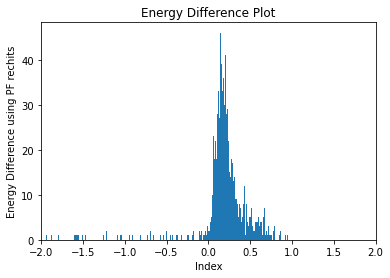

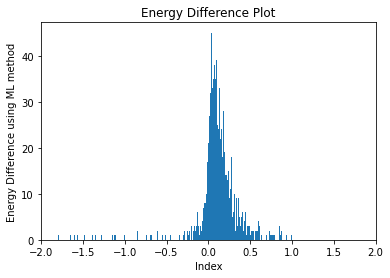

In [69]:
#### plot the diff of energy hists
# Plot the array
plt.hist(energyDiff_pf_array, bins=1000, range=(-3, 3))

# Set the x-axis range
x_min = -2  # Minimum x-value
x_max = 2   # Maximum x-value
plt.xlim(x_min, x_max)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Energy Difference using PF rechits')
plt.title('Energy Difference Plot')

# Display the plot
plt.show()


plt.hist(energyDiff_ps_array, bins=1000, range=(-3, 3))

# Set the x-axis range
x_min = -2  # Minimum x-value
x_max = 2  # Maximum x-value
plt.xlim(x_min, x_max)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Energy Difference using ML method')
plt.title('Energy Difference Plot')

# Display the plot
plt.show()

In [70]:
from scipy.stats import norm
from scipy.optimize import curve_fit

[0.80962403 0.15731195 0.08843279]


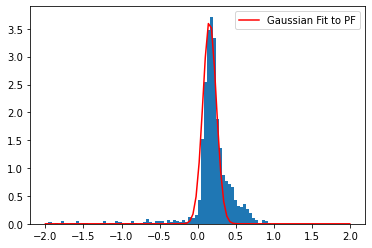

[0.81026787 0.0736166  0.09429819]


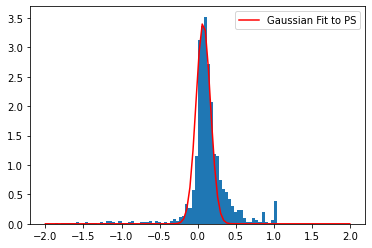

In [75]:
#### Fit both wigh Gaussian

bin_centers1, bin_edges1, _ = plt.hist(energyDiff_pf_array, bins=100, range=(-2, 2), density=True)
bin_width1 = bin_edges1[1] - bin_edges1[0]
#bin_centers = bin_centers * bin_width  # Scale the histogram values to match the area under the curve
bin_centers1 = bin_centers1  # Scale the histogram values to match the area under the curve
p0 = [1, 0.2, 0.08]  # Initial guess for the Gaussian parameters
#params, _ = curve_fit(gaussian, bin_edges[:-1], bin_centers, p0=p0)
params, _ = curve_fit(gaussian, bin_edges1[:-1], bin_centers1, p0=p0)

# Plot the fitted Gaussian curve
x = np.linspace(-2, 2, 100)
y = gaussian(x, *params)
plt.plot(x, y, 'r-', label='Gaussian Fit to PF')

print(params)
# Show the legend
plt.legend()

# Show the plot
plt.show()


bin_centers, bin_edges, _ = plt.hist(energyDiff_ps_array, bins=100, range=(-2, 2), density=True)
bin_width = bin_edges[1] - bin_edges[0]
#bin_centers = bin_centers * bin_width  # Scale the histogram values to match the area under the curve
bin_centers = bin_centers  # Scale the histogram values to match the area under the curve
p0 = [1, 0.2, 0.08]  # Initial guess for the Gaussian parameters
params, _ = curve_fit(gaussian, bin_edges[:-1], bin_centers, p0=p0)

# Plot the fitted Gaussian curve
x = np.linspace(-2, 2, 100)
y = gaussian(x, *params)
plt.plot(x, y, 'r-', label='Gaussian Fit to PS')

print(params)
# Show the legend
plt.legend()

# Show the plot
plt.show()



In [72]:
bin_midpoints = [(bin_edges1[i] + bin_edges1[i + 1]) / 2 for i in range(len(bin_edges1) - 1)]
rms_value1 = np.sqrt(np.sum(np.array(bin_midpoints)**2 * np.array(bin_centers1)) / len(bin_midpoints))
rms_value2 = np.sqrt(np.sum(np.array(bin_midpoints)**2 * np.array(bin_centers)) / len(bin_midpoints))

In [73]:
rms_value1

0.17335075839722539

In [74]:
rms_value2

0.163326159545406